# Feature importances


In [1]:
from data import load_data

train_data, test_data = load_data()

In [2]:
from pipelines import pipeline

train_data = pipeline.fit_transform(train_data)
train_data.head()

,hour_sin,hour_cos,bg-2:00,bg-1:55,bg-1:50,bg-1:45,bg-1:40,bg-1:35,bg-1:30,bg-1:25,...,p_num_p10,p_num_p11,p_num_p12,p_num_p15,p_num_p16,p_num_p18,p_num_p19,p_num_p21,p_num_p22,p_num_p24
id,,,,,,,,,,,,,,,,,,,,,
p01_0,1.412185,-0.053043,2.787336,2.886563,3.014918,3.110415,3.145659,3.145481,3.176226,3.146905,...,0,0,0,0,0,0,0,0,0,0
p01_1,1.405123,-0.145283,3.107238,3.142752,3.143014,3.174445,3.145659,3.081397,3.048118,2.986641,...,0,0,0,0,0,0,0,0,0,0
p01_2,1.392038,-0.236863,3.171219,3.142752,3.078966,3.046385,2.985433,2.889145,2.823928,2.858430,...,0,0,0,0,0,0,0,0,0,0
p01_3,1.372987,-0.327393,3.043258,2.982634,2.886821,2.822280,2.857253,2.857103,2.887982,2.858430,...,0,0,0,0,0,0,0,0,0,0
p01_4,1.348051,-0.416484,2.819326,2.854539,2.854797,2.886310,2.857253,2.857103,2.823928,2.698166,...,0,0,0,0,0,0,0,0,0,0


### HistGradientBoostingRegressor 

In [3]:
import os
import pandas as pd
from src.features.tuners import HistGradientBoostingHyperparameterTuner
from sklearn.inspection import permutation_importance

tuner = HistGradientBoostingHyperparameterTuner()
csv_file_name = os.path.join('features', f'{tuner.__name__}_top_feature_importances.csv')

if not os.path.exists(csv_file_name):
    X = train_data.drop(columns=['bg+1:00'])
    y = train_data['bg+1:00']

    model = tuner.regressor()
    model.fit(X, y)

    importances = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    top_feature_importances = pd.Series(importances.importances_mean, index=X.columns)
    top_feature_importances.to_csv(csv_file_name)

top_feature_importances = pd.read_csv(csv_file_name, index_col=0)
top_feature_importances

,0
hour_sin,0.019998
hour_cos,0.013838
bg-2:00,0.002499
bg-1:55,0.000673
bg-1:50,0.000253
...,...
p_num_p18,0.002673
p_num_p19,0.000983
p_num_p21,0.005555
p_num_p22,0.000565


## LassoLarsIC

In [4]:
from src.features.tuners import LassoLarsICHyperparameterTuner

tuner = LassoLarsICHyperparameterTuner()
csv_file_name = os.path.join('features', f'{tuner.__name__}_top_feature_importances.csv')

if not os.path.exists(csv_file_name):
    X = train_data.drop(columns=['bg+1:00'])
    y = train_data['bg+1:00']

    model = tuner.regressor()
    model.fit(X=X, y=y)

    top_feature_importances = pd.Series(abs(model.coef_), index=X.columns)
    top_feature_importances.to_csv(csv_file_name)

top_feature_importances = pd.read_csv(csv_file_name, index_col=0)
top_feature_importances

,0
hour_sin,0.155012
hour_cos,0.031435
bg-2:00,0.004043
bg-1:55,0.000000
bg-1:50,0.000000
...,...
p_num_p18,0.437862
p_num_p19,0.008456
p_num_p21,0.617936
p_num_p22,0.223001


## XGBRegressor

In [5]:
from src.features.tuners import XGBHyperparameterTuner

tuner = XGBHyperparameterTuner()
csv_file_name = os.path.join('features', f'{tuner.__name__}_top_feature_importances.csv')

if not os.path.exists(csv_file_name):
    X = train_data.drop(columns=['bg+1:00'])
    y = train_data['bg+1:00']

    model = tuner.regressor()
    model.fit(X=X, y=y)
    top_feature_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)
    top_feature_importances.to_csv(csv_file_name)

top_feature_importances = pd.read_csv(csv_file_name, index_col=0)
top_feature_importances

,0
hour_sin,0.005892
hour_cos,0.006324
bg-2:00,0.003189
bg-1:55,0.004381
bg-1:50,0.004893
...,...
p_num_p18,0.007458
p_num_p19,0.005987
p_num_p21,0.012908
p_num_p22,0.005845


# Summary

In [6]:
hgb_feature_importance = pd.read_csv(os.path.join('features', 'HistGradientBoostingRegressor_top_feature_importances.csv'), index_col=0)
hgb_feature_importance = hgb_feature_importance.rename(columns={'0': 'hgb_importance'})
hgb_feature_importance = hgb_feature_importance / hgb_feature_importance.sum()
mask = ~(hgb_feature_importance.index.str.startswith('hour') | hgb_feature_importance.index.str.startswith('p_num'))
hgb_feature_importance = hgb_feature_importance[mask]

llic_feature_importance = pd.read_csv(os.path.join('features', 'LassoLarsIC_top_feature_importances.csv'), index_col=0)
llic_feature_importance = llic_feature_importance.rename(columns={'0': 'llic_importance'})
llic_feature_importance = llic_feature_importance / llic_feature_importance.sum()
mask = ~(llic_feature_importance.index.str.startswith('hour') | llic_feature_importance.index.str.startswith('p_num'))
llic_feature_importance = llic_feature_importance[mask]

xgb_feature_importance = pd.read_csv(os.path.join('features', 'XGBRegressor_top_feature_importances.csv'), index_col=0)
xgb_feature_importance = xgb_feature_importance.rename(columns={'0': 'xgb_importance'})
xgb_feature_importance = xgb_feature_importance / xgb_feature_importance.sum()
mask = ~(xgb_feature_importance.index.str.startswith('hour') | xgb_feature_importance.index.str.startswith('p_num'))
xgb_feature_importance = xgb_feature_importance[mask]

feature_importance = pd.concat([hgb_feature_importance, llic_feature_importance, xgb_feature_importance], axis=1)
feature_importance

,hgb_importance,llic_importance,xgb_importance
bg-2:00,0.001572,0.000247,0.003189
bg-1:55,0.000424,0.000000,0.004381
bg-1:50,0.000159,0.000000,0.004893
bg-1:45,0.000219,0.000000,0.003358
bg-1:40,0.000354,0.001387,0.003753
...,...,...,...
cals-0:20,0.000199,0.000000,0.002604
cals-0:15,0.000070,0.000389,0.003440
cals-0:10,0.000141,0.000389,0.004339
cals-0:05,0.000284,0.000781,0.006485


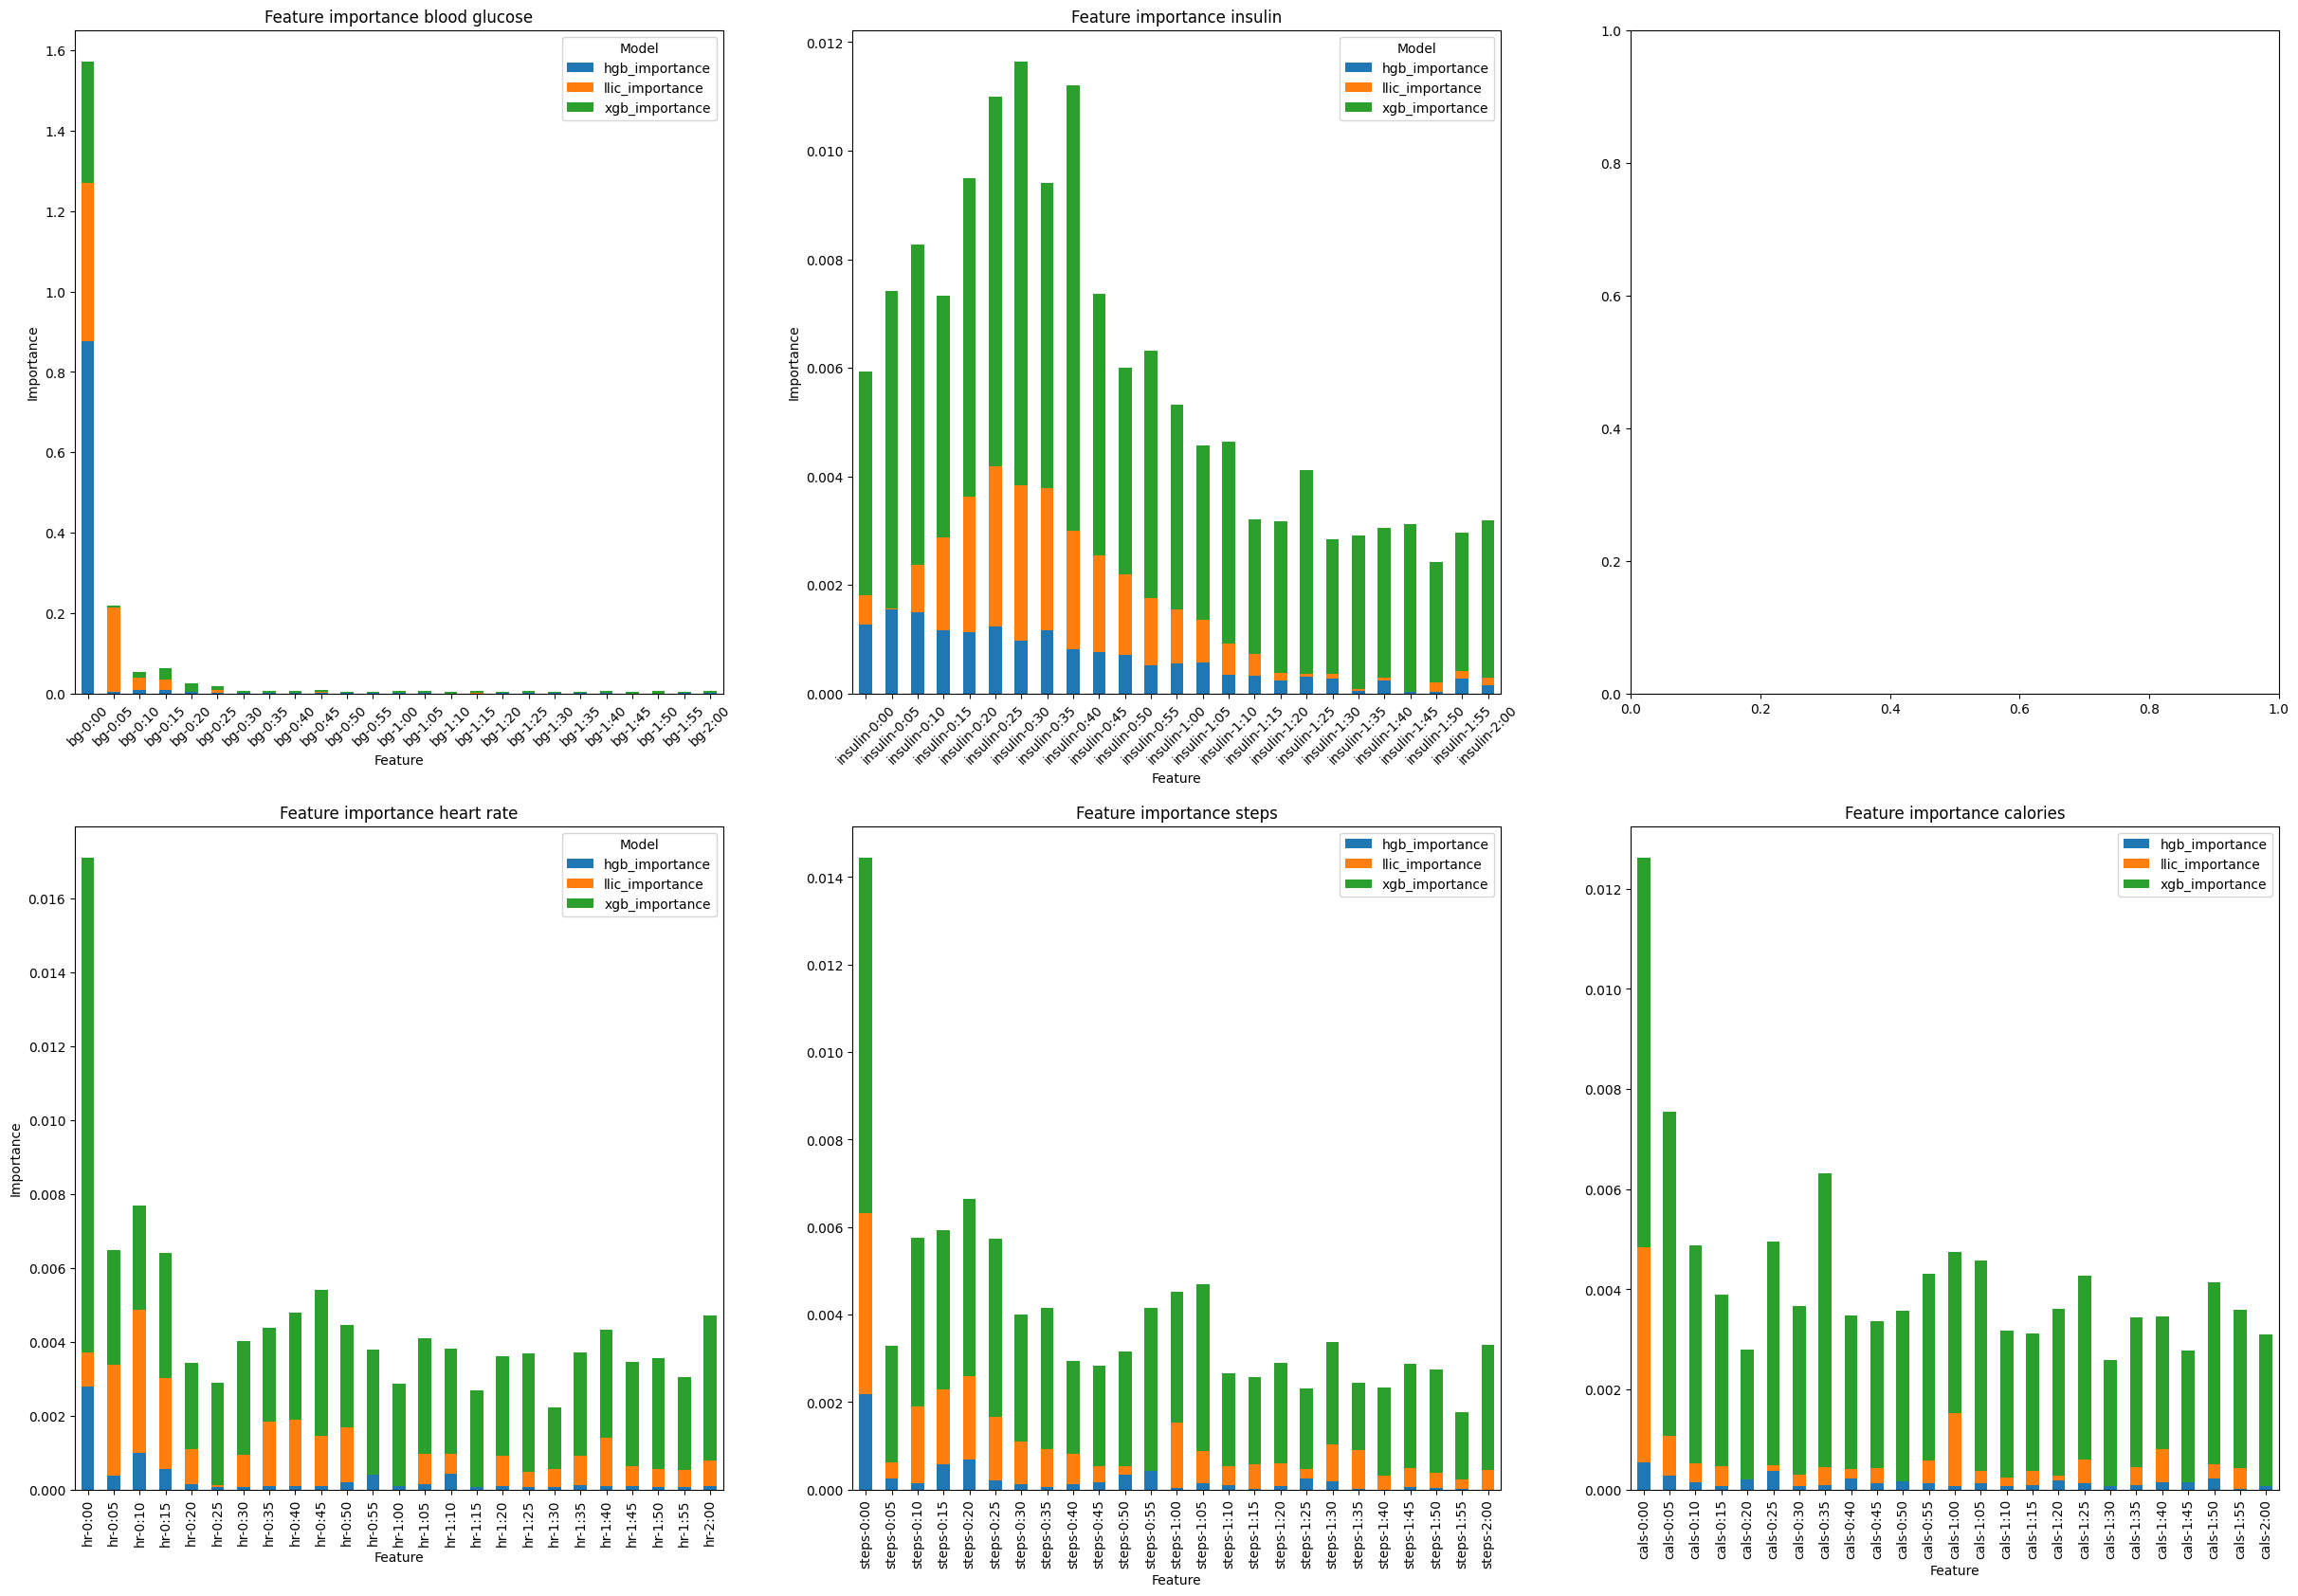

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

feature_importance_bg = feature_importance.loc[feature_importance.index.str.startswith('bg')]
feature_importance_bg = feature_importance_bg[::-1]  # Reverse order for better visualization

feature_importance_insulin = feature_importance.loc[feature_importance.index.str.startswith('insulin')]
feature_importance_insulin = feature_importance_insulin[::-1]  # Reverse order for better visualization

feature_importance_hr = feature_importance.loc[feature_importance.index.str.startswith('hr')]
feature_importance_hr = feature_importance_hr[::-1]  # Reverse order for better visualization

feature_importance_steps = feature_importance.loc[feature_importance.index.str.startswith('steps')]
feature_importance_steps = feature_importance_steps[::-1]  # Reverse order for better visualization

feature_importance_cals = feature_importance.loc[feature_importance.index.str.startswith('cals')]
feature_importance_cals = feature_importance_cals[::-1]  # Reverse order for better visualization

# show 2x3 plot
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(30, 20))
feature_importance_bg.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Feature importance blood glucose')
ax1.set_xlabel('Feature')
ax1.set_ylabel('Importance')
ax1.legend(title='Model')
ax1.xaxis.set_tick_params(rotation=45)

feature_importance_insulin.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Feature importance insulin')
ax2.set_xlabel('Feature')
ax2.set_ylabel('Importance')
ax2.legend(title='Model')
ax2.xaxis.set_tick_params(rotation=45)

ax3 = None

feature_importance_hr.plot(kind='bar', stacked=True, ax=ax4)
ax4.set_title('Feature importance heart rate')
ax4.set_xlabel('Feature')
ax4.set_ylabel('Importance')
ax4.legend(title='Model')

feature_importance_steps.plot(kind='bar', stacked=True, ax=ax5)
ax5.set_title('Feature importance steps')
ax5.set_xlabel('Feature')

feature_importance_cals.plot(kind='bar', stacked=True, ax=ax6)
ax6.set_title('Feature importance calories')
ax6.set_xlabel('Feature')

plt.show()


## final selection of features

* bg-0:00 - bg-1:00
* ins-0:00 - ins-1:00
* hr-0:00 - hr-1:00
* steps-0:00 - steps-1:00
* cals-0:00 - cals-1:00